The graph should be similar to this...

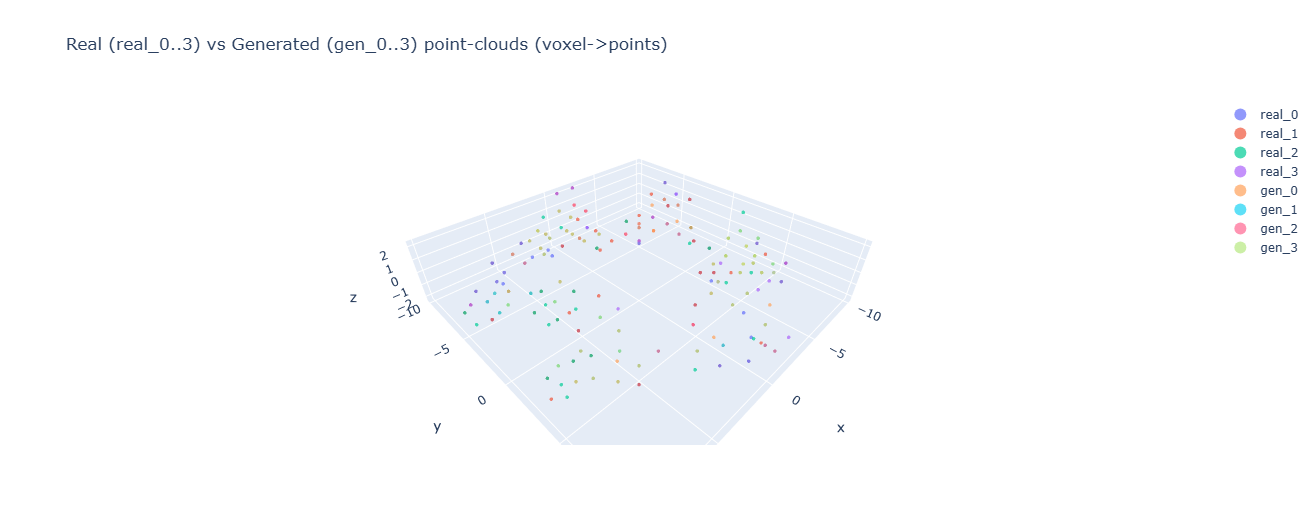

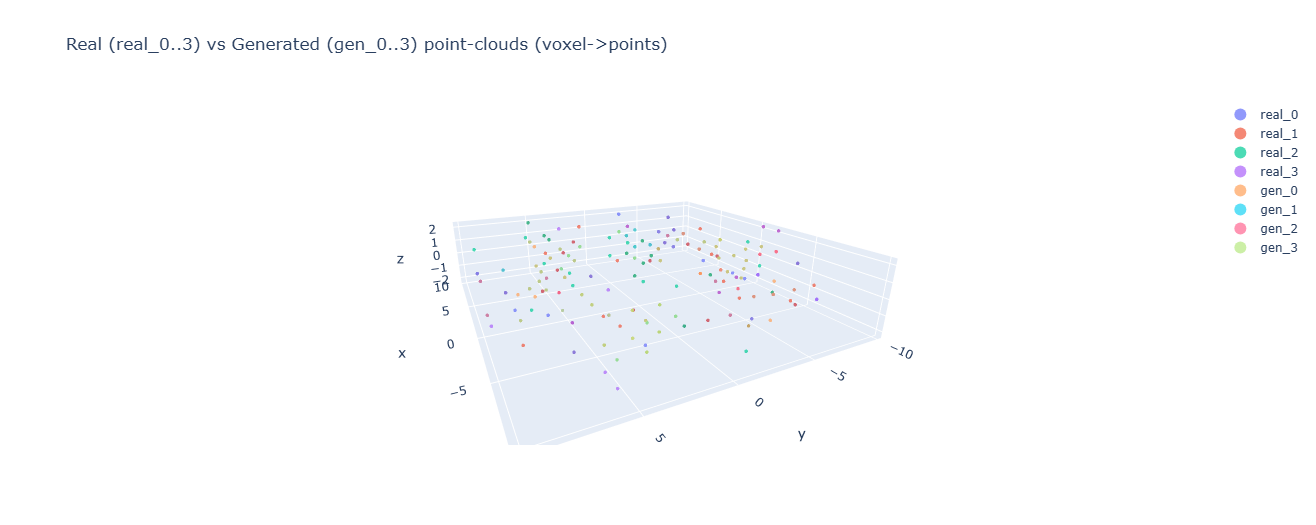

Install Packages!!

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install numpy plotly tqdm

Imports!!

In [ ]:
import os
import math
import random
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import plotly.graph_objects as go

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # strongly suggest you switcht to a gpu runtime!!!
print("Device:", device)


Device: cpu


Synthetic dataset: points on a lower-dimensional manifold in 3D

In [ ]:
class ManifoldMixture3D:
    """
    Sample points from a mixture of parametric curves / tubes in 3D.
    We'll create several rings and twisted curves. Then we voxelize.
    Flu is killing me!!
    """
    def __init__(self, n_modes=4, radius=8.0, scale=1.0, seed=42):
        self.n_modes = n_modes
        self.radius = radius
        self.scale = scale
        random.seed(seed)
        np.random.seed(seed)
        self.modes = []
        for i in range(n_modes):
            # random center offset and orientation
            theta = 2 * math.pi * i / n_modes
            cx = radius * math.cos(theta)
            cy = radius * math.sin(theta)
            cz = 0.0
            axis = np.random.randn(3)
            axis /= np.linalg.norm(axis)
            twist = np.random.uniform(0.5, 2.0)
            self.modes.append((cx, cy, cz, axis, twist))

    def sample_point(self, mode_idx):
        cx, cy, cz, axis, twist = self.modes[mode_idx]
        t = np.random.uniform(0, 2*np.pi)
        # parametric ring with some vertical oscillation -> manifold ~1D embedded in 3D
        x = cx + math.cos(t) * 2.0 + 0.5 * math.cos(t * twist)
        y = cy + math.sin(t) * 2.0 + 0.5 * math.sin(t * twist)
        z = cz + 1.5 * math.sin(2*t)  # small vertical variation
        # add small radial noise so it's a tube, not a line
        normal = np.random.randn(3)
        normal -= normal.dot(axis) * axis  # project out axis component
        normal /= (np.linalg.norm(normal) + 1e-9)
        r = np.random.normal(scale=0.15)  # tube radius
        x += normal[0]*r
        y += normal[1]*r
        z += normal[2]*r
        return np.array([x, y, z]) * self.scale

    def sample_batch_points(self, batch_size):
        pts = []
        modes = np.random.randint(0, self.n_modes, size=batch_size)
        for m in modes:
            pts.append(self.sample_point(m))
        return np.stack(pts, axis=0)  # (B,3)


Voxelization utilities

In [ ]:
def points_to_voxel_grid(points, grid_size=32, bbox=24.0, sigma=0.8):
    """
    points: (N,3) array in real-space centered near origin
    grid_size: int
    bbox: half-extent in each axis (so we map [-bbox, bbox] to grid)
    sigma: gaussian spread in world units
    Returns: voxel grid (grid_size,grid_size,grid_size) with values in [0,1]
    I miss the things
    """
    coords = (points + bbox) / (2*bbox)  # map to [0,1]
    coords = np.clip(coords, 0., 1.)
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    # precompute grid coordinates
    xs = np.linspace(0,1,grid_size)
    ys = np.linspace(0,1,grid_size)
    zs = np.linspace(0,1,grid_size)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
    # Add Gaussian contribution of each point
    for p in coords:
        dx = X - p[0]
        dy = Y - p[1]
        dz = Z - p[2]
        d2 = dx*dx + dy*dy + dz*dz
        grid += np.exp(-d2 / (2*(sigma/(2*bbox))**2))
    # normalize and clip
    grid = grid / (grid.max() + 1e-9)
    return grid.astype(np.float32)


Torch Dataset that yields voxel volumes

In [ ]:
class VoxelManifoldDataset(Dataset):
    def __init__(self, n_samples=2000, grid_size=32, points_per_sample=128, bbox=24.0):
        self.n_samples = n_samples
        self.grid_size = grid_size
        self.points_per_sample = points_per_sample
        self.bbox = bbox
        self.generator = ManifoldMixture3D(n_modes=6, radius=8.0)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        pts = self.generator.sample_batch_points(self.points_per_sample)  # (P,3)
        vox = points_to_voxel_grid(pts, grid_size=self.grid_size, bbox=self.bbox, sigma=0.7)
        # return as tensor with channel dim
        return torch.from_numpy(vox).unsqueeze(0)  # (1, D, D, D)


Model definitions: Generator (3D deconv) and Critic (3D conv)

In [ ]:
class Gen3D(nn.Module):
    def __init__(self, z_dim=128, out_channels=1, base=32, grid_size=32):
        super().__init__()
        # We'll start from a small dense representation and upsample with ConvTranspose3d
        self.z_dim = z_dim
        self.base = base
        self.init_dim = 4  # start from 4x4x4
        self.fc = nn.Linear(z_dim, base * 8 * self.init_dim**3)
        self.deconv = nn.Sequential(
            # input: (base*8) x 4 x 4 x 4
            nn.ConvTranspose3d(base*8, base*4, kernel_size=4, stride=2, padding=1), # 8x8x8
            nn.BatchNorm3d(base*4),
            nn.ReLU(True),
            nn.ConvTranspose3d(base*4, base*2, kernel_size=4, stride=2, padding=1), # 16x16x16
            nn.BatchNorm3d(base*2),
            nn.ReLU(True),
            nn.ConvTranspose3d(base*2, base, kernel_size=4, stride=2, padding=1),   # 32x32x32
            nn.BatchNorm3d(base),
            nn.ReLU(True),
            nn.Conv3d(base, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        B = z.shape[0]
        x = self.fc(z).view(B, self.base*8, self.init_dim, self.init_dim, self.init_dim)
        x = self.deconv(x)
        return x  # (B,1,D,D,D)

class Critic3D(nn.Module):
    def __init__(self, in_channels=1, base=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_channels, base, kernel_size=4, stride=2, padding=1), # 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base, base*2, kernel_size=4, stride=2, padding=1), # 8
            nn.InstanceNorm3d(base*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base*2, base*4, kernel_size=4, stride=2, padding=1), # 4
            nn.InstanceNorm3d(base*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(base*4, 1, kernel_size=4), # final spatial size 1
        )
    def forward(self, x):
        out = self.net(x)
        return out.view(x.shape[0], -1).mean(1)  # return scalar critic score per sample


WGAN-GP loss helpers

In [ ]:
def gradient_penalty(critic, real, fake, device='cpu', lambda_gp=10.0):
    B = real.shape[0]
    alpha = torch.rand(B, 1, 1, 1, 1, device=device)
    alpha = alpha.expand_as(real)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    grads = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grads = grads.view(B, -1)
    grad_norm = grads.norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean() * lambda_gp
    return gp


Small training loop

In [ ]:
# Hyperparams
z_dim = 128
grid_size = 32
batch_size = 32
n_epochs = 6
critic_iters = 5
lr = 1e-4

# Create dataset & loader
dataset = VoxelManifoldDataset(n_samples=1000, grid_size=grid_size, points_per_sample=128, bbox=24.0)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)

# Instantiate models
gen = Gen3D(z_dim=z_dim, out_channels=1, base=24, grid_size=grid_size).to(device)
critic = Critic3D(in_channels=1, base=24).to(device)

opt_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
opt_c = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

fixed_z = torch.randn(8, z_dim, device=device)

# Training loop
it = 0
for epoch in range(n_epochs):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for real in pbar:
        real = real.to(device)  # (B,1,D,D,D)
        B = real.shape[0]
        # Train critic multiple times
        for _ in range(critic_iters):
            z = torch.randn(B, z_dim, device=device)
            fake = gen(z).detach()
            c_real = critic(real)
            c_fake = critic(fake)
            gp = gradient_penalty(critic, real, fake, device=device, lambda_gp=10.0)
            loss_c = -(c_real.mean() - c_fake.mean()) + gp
            opt_c.zero_grad()
            loss_c.backward()
            opt_c.step()
        # Train generator
        z = torch.randn(B, z_dim, device=device)
        fake = gen(z)
        loss_g = -critic(fake).mean()
        opt_g.zero_grad()
        loss_g.backward()
        opt_g.step()
        it += 1
        pbar.set_postfix({'loss_c': loss_c.item(), 'loss_g': loss_g.item()})
    # Show a small sample after each epoch
    with torch.no_grad():
        samples = gen(fixed_z).cpu().numpy()  # (8,1,D,D,D)
    # Save last epoch samples for visualization outside loop
    last_samples = samples.copy()


Epoch 6/6: 100%|██████████| 31/31 [15:21<00:00, 29.71s/it, loss_c=-2.31, loss_g=-3.54]


Convert voxel to point cloud for plotting

In [ ]:
def voxel_to_pointcloud(voxel, bbox=24.0, threshold=0.2, max_points=2048):
    """
    voxel: (D,D,D) numpy array
    returns: (N,3) points in world coordinates
    """
    D = voxel.shape[0]
    # choose indices where voxel > threshold
    idx = np.argwhere(voxel > threshold)
    if idx.shape[0] == 0:
        return np.zeros((0,3), dtype=float)
    # if too many, sample
    if idx.shape[0] > max_points:
        perm = np.random.choice(idx.shape[0], max_points, replace=False)
        idx = idx[perm]
    # idx in grid coords (i,j,k) -> map to world coords in [-bbox, bbox]
    coords = (idx + 0.5) / D * 2*bbox - bbox
    return coords[:, [0,1,2]]  # return (N,3)


Plotly visualizations: real vs generated

In [ ]:
# pick a few real samples
real_samples = []
for i in range(4):
    vox = dataset[i].numpy().squeeze(0)  # (D,D,D)
    pc = voxel_to_pointcloud(vox, bbox=dataset.bbox, threshold=0.2, max_points=1500)
    real_samples.append(pc)

# pick generated samples from last_samples
gen_samples = []
for i in range(min(4, last_samples.shape[0])):
    vox = last_samples[i,0]
    pc = voxel_to_pointcloud(vox, bbox=dataset.bbox, threshold=0.2, max_points=1500)
    gen_samples.append(pc)

def make_scatter_trace(points, name, marker_size=2):
    if points.shape[0] == 0:
        # fallback single point at origin
        return go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', name=name, marker=dict(size=2))
    return go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', name=name,
                        marker=dict(size=marker_size, opacity=0.7))

fig = go.Figure()

# Add 4 real samples (smaller subplots accomplished by offsetting traces with titles)
for i, pc in enumerate(real_samples):
    fig.add_trace(make_scatter_trace(pc, f"real_{i}"))

for i, pc in enumerate(gen_samples):
    fig.add_trace(make_scatter_trace(pc, f"gen_{i}"))

fig.update_layout(
    title="Real (real_0..3) vs Generated (gen_0..3) point-clouds (voxel->points)",
    scene=dict(
        xaxis=dict(title='x'),
        yaxis=dict(title='y'),
        zaxis=dict(title='z'),
        aspectmode='data'
    ),
    legend=dict(itemsizing='constant')
)
fig.show()
